# Reddit r/NFT Sentiment Data

In [351]:
#
import os
import numpy as np
import pandas as pd
from pandas import Timestamp
import seaborn as sns
import matplotlib.pyplot as plt
#
import datetime
from dateutil.relativedelta import relativedelta
import requests
import praw
from psaw import PushshiftAPI
#
import nltk
import re
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
import emoji

Authentication (using PRAW and PSAW since PRAW allows only 1000 responses)

In [75]:
with open("KEY", 'r') as file:
    CLIENT_ID, CLIENT_SECRET = file.read().splitlines()

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri="http://localhost:8080",
    user_agent="NFT_Sent:v1.0 (by u/Sharp_Source3201)",
)
print(reddit.auth.url(["identity"], "...", "permanent"))

api = PushshiftAPI(reddit)

https://www.reddit.com/api/v1/authorize?client_id=PwwNhIZjaOAKPHnD15vVsg&duration=permanent&redirect_uri=http%3A%2F%2Flocalhost%3A8080&response_type=code&scope=identity&state=...


Post parse function

In [242]:
def get_features(submission):
    date = datetime.datetime.fromtimestamp(submission.created).date()
    title = submission.title
    main_text = submission.selftext
    
    return date, title, main_text

Subreddit search submission through PSAW (returns Submission objects), segmenting for time (~2.5 hours total)

In [277]:
%%time
#start_epoch=int(datetime.datetime(2017, 10, 2).timestamp())
start_epoch=int(datetime.datetime(2022, 4, 17).timestamp())
end_epoch=int(datetime.datetime(2022, 4, 18).timestamp())
#end_epoch=int(datetime.datetime(2022, 4, 17).timestamp())

query = "NOT title:giveaway"

request_results = list(api.search_submissions(#q=query,
                            after=start_epoch,
                            before=end_epoch,
                            subreddit="NFT",
                            filter=['title', 'selftext'],
                            ))

#subreddit = reddit.subreddit("NFT")

CPU times: total: 1.09 s
Wall time: 5.71 s


In [278]:
len(request_results)

453

In [260]:
df = pd.DataFrame([get_features(sub) for sub in request_results], columns=["Date", "Title", "Selftext"])

## Cleaning Main Data

In [293]:
df = pd.read_csv("../data/signals/Reddit_NFT_Text.csv")
df.head()

,Unnamed: 0,Date,Title,Selftext
0,0,2020-12-01,Robin Williams LU-ME Lamp,Just dropped my first NFT on [@rariblecom](htt...
1,1,2020-12-01,How to create your first NFT in 1 minute,NaN
2,2,2020-12-01,"The Six Dragons: PS5, DeFi, Yield Farming",NaN
3,3,2020-12-01,A new NFT with a low supply coin and NFT staki...,NaN
4,4,2020-12-01,Read more about the first mind-controlled NFT ...,NaN


Turn date column into datetime and sort

In [294]:
df['Date'] = pd.to_datetime(df['Date'])

In [308]:
df = df.sort_values("Date").drop(df.columns[0], axis=1)
df.head()

,Date,Title,Selftext
459,2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,NaN
458,2019-02-28,Decentraland Creator Contest - Building on NFT...,NaN
457,2019-02-28,NFTY News,NaN
456,2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,NaN
454,2019-07-06,Yat Siu - NFT is why content will be king again,NaN


In [310]:
df.index = pd.DatetimeIndex(df["Date"])
df.head()

,Date,Title,Selftext
Date,,,
2019-02-28,2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,NaN
2019-02-28,2019-02-28,Decentraland Creator Contest - Building on NFT...,NaN
2019-02-28,2019-02-28,NFTY News,NaN
2019-02-28,2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,NaN
2019-07-06,2019-07-06,Yat Siu - NFT is why content will be king again,NaN


In [311]:
df = df.drop("Date", axis=1)
df.head()

,Title,Selftext
Date,,
2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,NaN
2019-02-28,Decentraland Creator Contest - Building on NFT...,NaN
2019-02-28,NFTY News,NaN
2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,NaN
2019-07-06,Yat Siu - NFT is why content will be king again,NaN


Output

In [312]:
df.to_csv("../data/signals/Reddit_NFT_Text.csv")

## Applying Sentiment Analysis

In [315]:
df = pd.read_csv("../data/signals/Reddit_NFT_Text.csv")
df.head()

,Date,Title,Selftext
0,2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,NaN
1,2019-02-28,Decentraland Creator Contest - Building on NFT...,NaN
2,2019-02-28,NFTY News,NaN
3,2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,NaN
4,2019-07-06,Yat Siu - NFT is why content will be king again,NaN


In [427]:
df = df.fillna("")
df["Comb"] = df["Title"] + ". " + df["Selftext"]
df.head()

,Date,Title,Selftext,Comb
0,2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,,A NonFungible Token Stampede Is Coming – Coinm...
1,2019-02-28,Decentraland Creator Contest - Building on NFT...,,Decentraland Creator Contest - Building on NFT...
2,2019-02-28,NFTY News,,NFTY News.
3,2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,,‘No Wallet Needed’: Mobile Cryptopunk Game.
4,2019-07-06,Yat Siu - NFT is why content will be king again,,Yat Siu - NFT is why content will be king again.


Dealing with emojis in text, sentiment data for all of them is not available so just convert them to text (Demojize)

In [400]:
test_string = df.iloc[267717, :].Title
test_string = emoji.demojize(test_string, delimiters=("","")).replace("_", " ")
print(test_string)

police car light EGGHUNT HAPPENING NOW rabbit face! DESCRIPTION IN COMMENTS eyes


spacy pipeline, demojize on the entire column is too intensive so just ignore them

In [437]:
%%time
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe('spacytextblob')

#raw_docs = (emoji.demojize(". ".join((row.Title, row.Selftext)), delimiters=("","")).replace("_", " ") for row in df.itertuples())
    
df["Polarity"] = [doc._.blob.polarity for doc in nlp.pipe(df["Comb"], batch_size=1000)]

CPU times: total: 25min 19s
Wall time: 25min 34s


Groupby date and aggregate the polarity for each day (also add the two years before, assume neutral since no NFT posts on the subreddit, did it manually by editing .csv)

In [468]:
df = pd.read_csv("../data/signals/Reddit_NFT_Sent.csv")

In [470]:
df.index = pd.DatetimeIndex(df["Date"])
df = df.drop(["Unnamed: 0", "Date"], axis=1)
df.head()

,Title,Selftext,Comb,Polarity
Date,,,,
2017-10-02,NaN,NaN,NaN,0.0
2019-02-28,A NonFungible Token Stampede Is Coming – Coinm...,NaN,A NonFungible Token Stampede Is Coming – Coinm...,0.0
2019-02-28,Decentraland Creator Contest - Building on NFT...,NaN,Decentraland Creator Contest - Building on NFT...,0.0
2019-02-28,NFTY News,NaN,NFTY News.,0.0
2019-02-28,‘No Wallet Needed’: Mobile Cryptopunk Game,NaN,‘No Wallet Needed’: Mobile Cryptopunk Game.,-0.4


In [511]:
pol_df = df.resample("D").sum().fillna(0).round(2).rename(columns={"Polarity":"Polarity_Sum"})
pol_df["Polarity_Mean"] = df.resample("D").mean().fillna(0).round(2)["Polarity"]
pol_df

,Polarity_Sum,Polarity_Mean
Date,,
2017-10-02,0.00,0.00
2017-10-03,0.00,0.00
2017-10-04,0.00,0.00
2017-10-05,0.00,0.00
2017-10-06,0.00,0.00
...,...,...
2022-04-13,69.98,0.15
2022-04-14,66.05,0.13
2022-04-15,61.89,0.14


Checking counts based on mean and sum aggregates

In [514]:
conditions = (pol_df["Polarity_Sum"] < 0.0, pol_df["Polarity_Sum"] == 0.0, pol_df["Polarity_Sum"] > 0.0)
choices = (-1, 0, 1)

np.unique(np.select(conditions, choices, default=0), return_counts=True)

(array([-1,  0,  1]), array([  20, 1054,  585], dtype=int64))

In [515]:
conditions = (pol_df["Polarity_Mean"] < 0.0, pol_df["Polarity_Mean"] == 0.0, pol_df["Polarity_Mean"] > 0.0)
choices = (-1, 0, 1)

np.unique(np.select(conditions, choices, default=0), return_counts=True)

(array([-1,  0,  1]), array([  20, 1054,  585], dtype=int64))

In [516]:
conditions = (pol_df["Polarity_Mean"] < 0.0, pol_df["Polarity_Mean"] == 0.0, pol_df["Polarity_Mean"] > 0.0)
choices = (-1, 0, 1)

pol_df["Sentiment"] = np.select(conditions, choices, default=0)
pol_df

,Polarity_Sum,Polarity_Mean,Sentiment
Date,,,
2017-10-02,0.00,0.00,0
2017-10-03,0.00,0.00,0
2017-10-04,0.00,0.00,0
2017-10-05,0.00,0.00,0
2017-10-06,0.00,0.00,0
...,...,...,...
2022-04-13,69.98,0.15,1
2022-04-14,66.05,0.13,1
2022-04-15,61.89,0.14,1


In [ ]:
pol_df.to_csv("../data/")

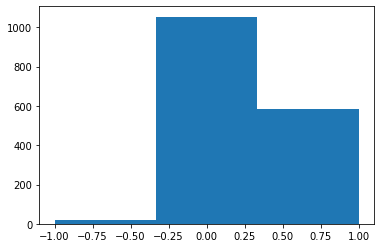

In [517]:
_ = plt.hist(pol_df["Sentiment"].values, bins=3)